In [1]:
# from IPython.display import Image, display
# display(Image(filename='../additional_files/accTosf_algo.png'))

In [2]:
from scipy.signal import find_peaks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import import_ipynb
from base_functions import *
# Frequency sampling
FS = 32
# Valid duration
T = 10
# Segment threshold
A = 0.3
# Max and Min frequency (in Hz)
F_min = 1.4
F_max = 2.3
# Parameters for "max equation"
alpha = 31.7
beta = 1.4

importing Jupyter notebook from base_functions.ipynb


In [3]:
def peak2peak(magnitude_vec: np.ndarray) -> float:
    peaks_idx, _ = find_peaks(magnitude_vec)
    if(peaks_idx.size > 1):
        peaks_value = magnitude_vec[peaks_idx]
        sorted_idx = np.argsort(peaks_value)
        return peaks_value[sorted_idx[-1]] - peaks_value[sorted_idx[-2]]
    return 0

In [4]:
# Read data
df = pd.read_csv('../recordings/walking_metronome/ACC.csv', skiprows=2, header=None)
df.columns = ['x', 'y', 'z']
magnitude = np.linalg.norm(df, axis=1)-1

In [5]:
# Split data into segments
magnitude = magnitude[:len(magnitude)-len(magnitude)%32]
magnitude_segments = magnitude.reshape(-1,FS)

In [6]:
# Calculate peak-to-peak amp in each segment
ptp_amp = np.apply_along_axis(peak2peak,axis=1,arr=magnitude_segments)

In [7]:
# Find segments above A
magnitude_segments[ptp_amp < A] = 0

In [8]:
# define wavelet function used in method
wavelet = ('gmw', {'beta': 90, 'gamma': 3})
magnitude_cwt, freqs_interp, coefs_interp = compute_cwt(acc_sginal=magnitude, wavelet=wavelet, fs=FS)

#TODO: use functions from base_functions.ipyb in order to calculate cadence
# cadence  = find_walking(magnitude=magnitude, magnitude_segments=magnitude, fs=FS, 
#                         step_freq=(1.4, 2.3), alpha=alpha,beta=beta, min_t=3, delta=20)

In [8]:
# # Ask Eran about cone of influance
# from scipy.signal.windows import tukey
# # Create window for CWT, M=(number of valid segments)*(Length of segment)
# # window = tukey(np.sum(ptp_amp > A)*FS, alpha=0.02, sym=True)
# window = tukey(len(magnitude), alpha=0.02, sym=True)

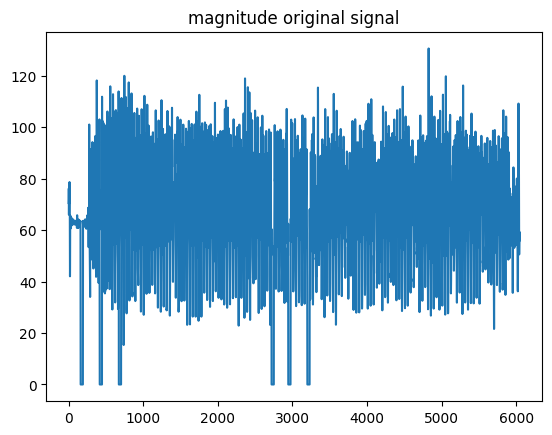

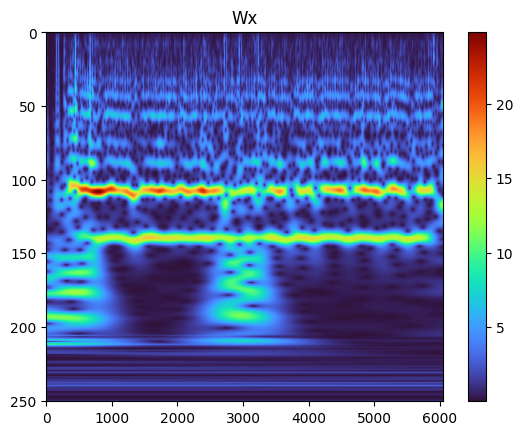

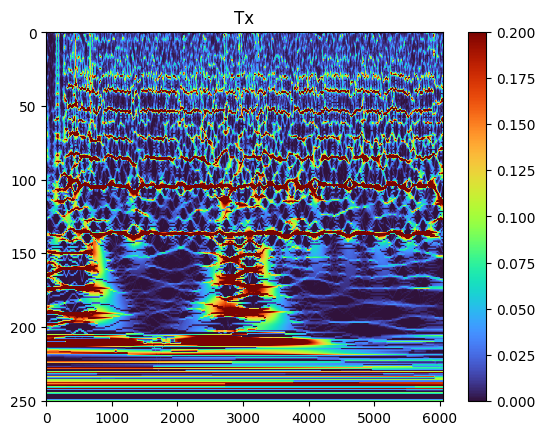

In [9]:
def viz(Tx, Wx):
    plt.imshow(np.abs(Wx), aspect='auto', cmap='turbo')
    plt.colorbar()
    plt.title('Wx')
    plt.show()
    plt.imshow(np.abs(Tx), aspect='auto', vmin=0, vmax=.2, cmap='turbo')
    plt.colorbar()
    plt.title('Tx')
    plt.show()

plt.title('magnitude original signal')
plt.plot(magnitude[:-1]); plt.show()

Twxo, Wxo, *_ = magnitude_cwt
viz(Twxo, Wxo)

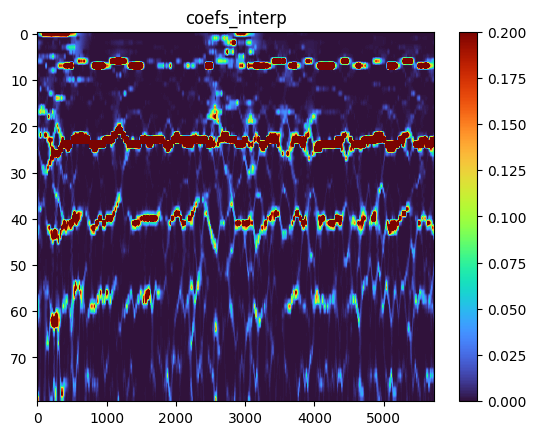

In [10]:
plt.imshow(np.abs(coefs_interp), aspect='auto', vmin=0, vmax=.2, cmap='turbo')
plt.colorbar()
plt.title('coefs_interp')
plt.show()
